In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import random
import os
from tabulate import tabulate
from tqdm import tqdm
import time
import warnings

from sklearn.model_selection import (StratifiedShuffleSplit, StratifiedKFold,
                                     RandomizedSearchCV, train_test_split)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, balanced_accuracy_score,
                             precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, HistGradientBoostingClassifier, 
                              VotingClassifier)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import (make_column_transformer, make_column_selector)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import (BalancedRandomForestClassifier, BalancedBaggingClassifier)
from skopt import BayesSearchCV
from sklearn.calibration import CalibratedClassifierCV

warnings.filterwarnings("ignore")
%matplotlib inline
from memory_profiler import profile
from skopt.space import Real, Integer, Categorical
from sklearn.calibration import calibration_curve


In [2]:
df = pd.read_csv("payments_00.csv") 

In [3]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.shape

(6362620, 11)

In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
## Consideration 1: Imbalanced Data
# - The `isFlaggedFraud` column indicates whether a transaction has been flagged as fraud by the system.
# - However, if the majority of transactions are not flagged as fraud (mean value is extremely low), including this column might not provide much predictive power.
# - Imbalanced data can bias the model towards the majority class (non-fraudulent transactions) and hinder the detection of actual fraud instances.

# Consideration 2: Model Interpretability
# - Including the `isFlaggedFraud` column might add noise to the model, especially if it doesn't significantly contribute to the classification task.
# - Removing this column could simplify the model and improve interpretability by focusing on more relevant features.

# Consideration 4: Dimensionality Reduction
# - Dropping the `isFlaggedFraud` column can help reduce the dimensionality of the dataset.
# - This is beneficial for algorithms sensitive to high-dimensional data and can also improve computational efficiency.

df.drop('isFlaggedFraud',axis = 1, inplace = True )

In [9]:
df.isnull().sum()

#there are no missing values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [10]:
#checking duplicate values 
df.duplicated().sum()

np.int64(0)

In [12]:
fraud_min_max = [
    ['amount', df.amount.min(), df.amount.max()],
    ['oldbalanceOrgg', df.oldbalanceOrg.min(), df.oldbalanceOrg.max()],
    ['newbalanceOrig', df.newbalanceOrig.min(), df.newbalanceOrig.max()],
    ['oldbalanceDest', df.oldbalanceDest.min(), df.oldbalanceDest.max()],
    ['isFraud', df.isFraud.min(), df.isFraud.max()],
    ['newbalanceDest', df.newbalanceDest.min(), df.newbalanceDest.max()]
]

# Format numbers to avoid scientific notation
fraud_min_max_formatted = [
    [col, "{:,.2f}".format(min_val), "{:,.2f}".format(max_val)] if isinstance(min_val, float) else [col, min_val, max_val]
    for col, min_val, max_val in fraud_min_max
]

print(tabulate(
    fraud_min_max_formatted,
    headers=['columns', 'min', 'max'],
    showindex=True,
    tablefmt='github',
    numalign='right')
)


|    | columns        |   min | max            |
|----|----------------|-------|----------------|
|  0 | amount         |     0 | 92,445,516.64  |
|  1 | oldbalanceOrgg |     0 | 59,585,040.37  |
|  2 | newbalanceOrig |     0 | 49,585,040.37  |
|  3 | oldbalanceDest |     0 | 356,015,889.35 |
|  4 | isFraud        |     0 | 1              |
|  5 | newbalanceDest |     0 | 356,179,278.92 |


In [11]:
#downcast numerical columns with smaller dtypes
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col],downcast = 'float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col],downcast = 'unsigned')

#use category dtype for category column
df['type'] = df['type'].astype('category')



In [4]:
def positive_class_ratio(y_test):
    y_test = np.array(y_test)
    positive_count = np.sum(y_test == 1)
    total_count = len(y_test)
    positive_ratio = positive_count / total_count
    print("Ratio of Positive Classes: ", positive_ratio)
    return positive_ratio


In [13]:
strat_train_set_f,strat_test_set_f=train_test_split(df,test_size=0.2,stratify=df["isFraud"],random_state=42)

In [14]:
#StratifiedSplit

splitter = StratifiedShuffleSplit(n_splits = 10,test_size = 0.2,random_state =19)
strat_splits = []
for train_index,test_index in splitter.split(strat_train_set_f,strat_train_set_f['isFraud']):
    strat_train_set_n = df.loc[train_index]
    strat_test_set_n = df.loc[test_index]
    strat_splits.append([strat_train_set_n,strat_test_set_n])
    


strat_train_set, strat_test_set = strat_splits[0]
strat_train_set_1,strat_test_set_1 = strat_splits[1]
strat_train_set_2,strat_test_set_2 = strat_splits[2]

strat_train_set_2,strat_test_set_2 = strat_splits[2]
strat_train_set_3,strat_test_set_3 = strat_splits[3]
strat_train_set_4,strat_test_set_4 = strat_splits[4]

strat_train_set_5,strat_test_set_5 = strat_splits[5]
strat_train_set_6,strat_test_set_6 = strat_splits[6]
strat_train_set_7,strat_test_set_7 = strat_splits[7]


In [16]:
explo_splits = []
for train_index,test_index in splitter.split(strat_test_set,strat_test_set['isFraud']):
    explo_train_set_n = df.loc[train_index]
    explo_test_set_n = df.loc[test_index]
    explo_splits.append([explo_train_set_n,explo_test_set_n])

# Retrieving the first split for exploratory data analysis

explo_train_set, explo_test_set = explo_splits[0]

explo_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 814416 entries, 106880 to 40172
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   step            814416 non-null  uint16  
 1   type            814416 non-null  category
 2   amount          814416 non-null  float64 
 3   nameOrig        814416 non-null  object  
 4   oldbalanceOrg   814416 non-null  float64 
 5   newbalanceOrig  814416 non-null  float64 
 6   nameDest        814416 non-null  object  
 7   oldbalanceDest  814416 non-null  float64 
 8   newbalanceDest  814416 non-null  float64 
 9   isFraud         814416 non-null  uint8   
dtypes: category(1), float64(5), object(2), uint16(1), uint8(1)
memory usage: 52.8+ MB


In [17]:
explo_train_set_demo, explo_test_set_demo = explo_splits[1]

In [18]:
# Assuming explo_train_set_demo is your dataframe
explo_train_set_demo.to_csv(r'C:\Users\swaga\Desktop\Desktop_files\temp\explo_train_set_demo.csv', index=False)


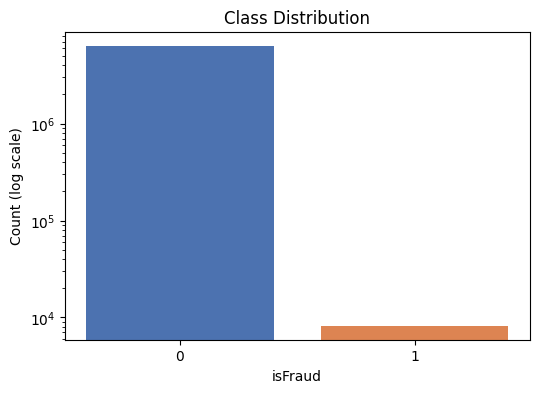

In [18]:
#using log-scale to visualize better
colors = sns.color_palette("deep")
plt.figure(figsize=(6, 4))
plt.bar(['0', '1'], [6354407, 8213], color=colors)
plt.yscale('log')
plt.xlabel('isFraud')
plt.ylabel('Count (log scale)')
plt.title('Class Distribution')
plt.show()

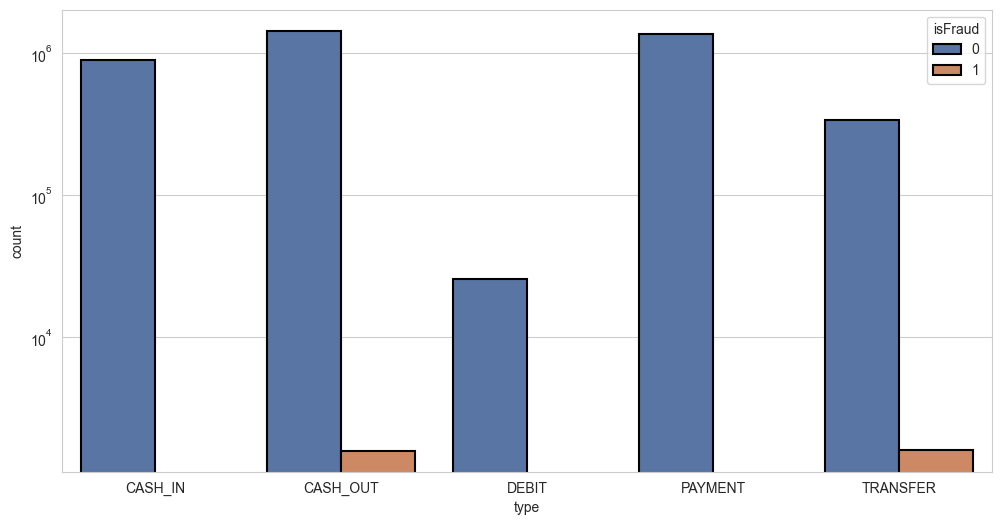

In [19]:
sns.set_style("whitegrid")

# Create a color palette with only two colors (for 'Not Fraud' and 'Fraud')
palette = sns.color_palette("deep", 2)

# Plot countplot with hue for isFraud and log scale
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='type', hue='isFraud', data=strat_train_set, palette=palette, edgecolor='black', linewidth=1.5)
ax.set_yscale('log')


plt.show()

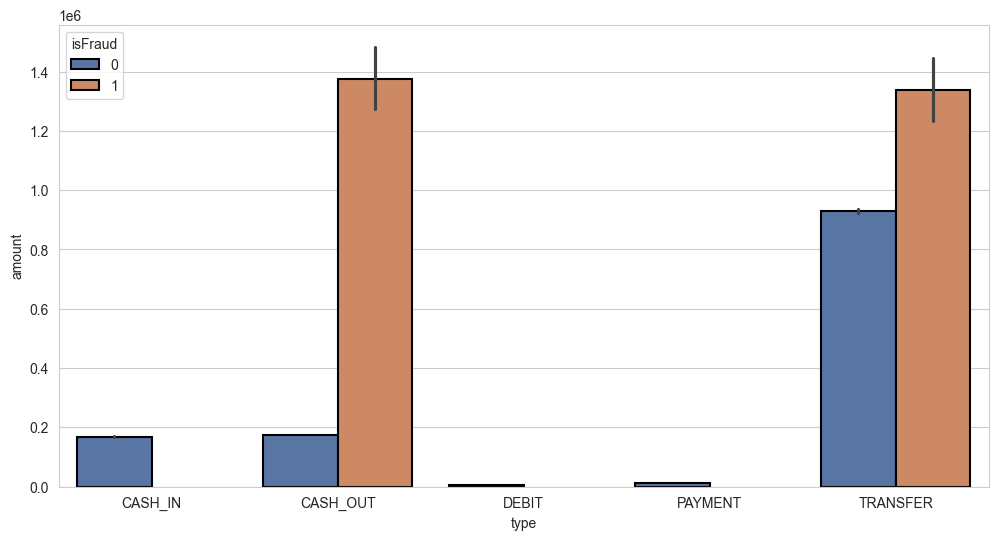

In [20]:
sns.set_style("whitegrid")

# Create a color palette with only two colors (for 'Not Fraud' and 'Fraud')
palette = sns.color_palette("deep", 2)

# Plot countplot with hue for isFraud and log scale
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='type', y ='amount', hue='isFraud', data=strat_train_set, palette=palette, edgecolor='black', linewidth=1.5)



plt.show()

<Figure size 1500x600 with 0 Axes>

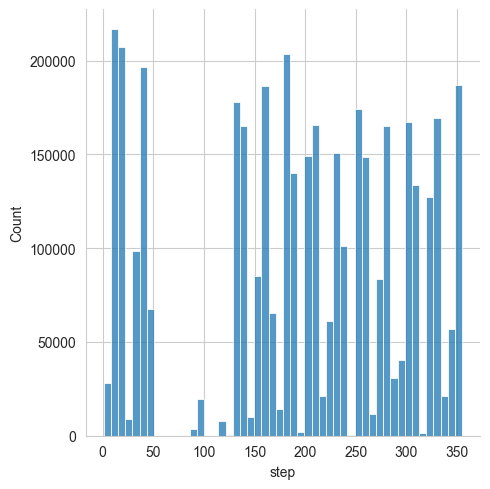

In [21]:

sns.set_style("whitegrid")
palette = sns.diverging_palette(230,20)
plt.figure(figsize=(15, 6))
sns.displot(strat_train_set['step'], bins=50)

In [22]:
strat_train_set.drop(["nameOrig","nameDest"],axis = 1,inplace = True)

In [23]:
strat_train_set_temp = strat_train_set.drop("type",axis = 1)

In [24]:
strat_train_set_temp.corr()["isFraud"].sort_values(ascending = False)

isFraud           1.000000
amount            0.051127
oldbalanceOrg     0.005837
newbalanceDest   -0.000356
step             -0.005405
oldbalanceDest   -0.005451
newbalanceOrig   -0.007201
Name: isFraud, dtype: float64

<Axes: >

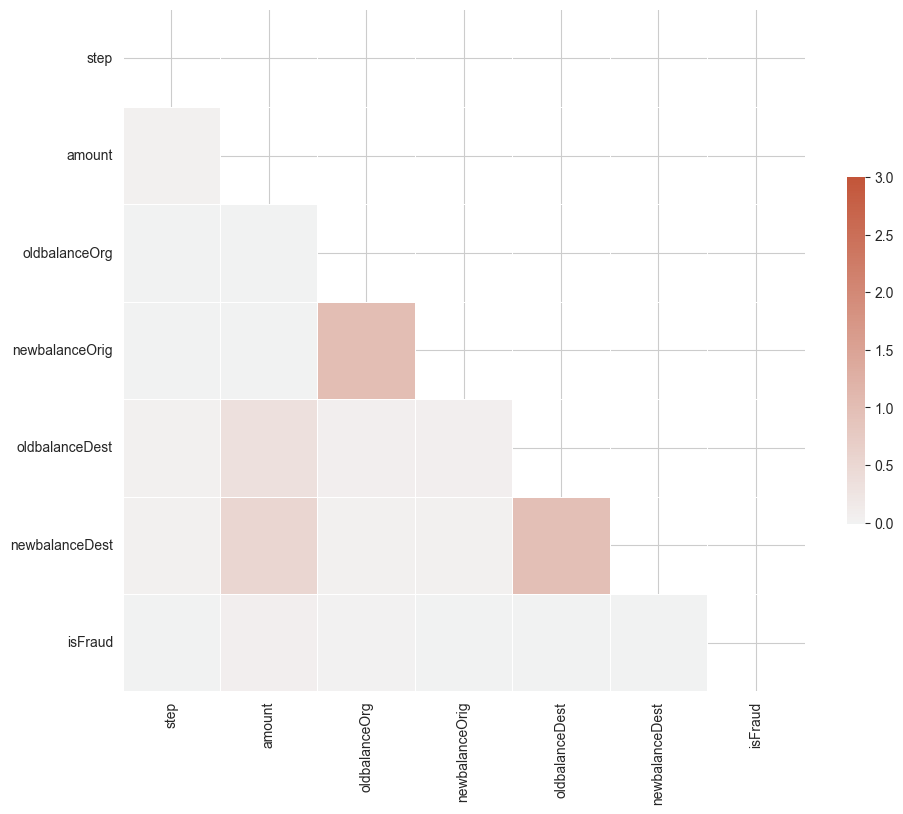

In [25]:
corr = strat_train_set_temp.corr()
mask = np.triu(np.ones_like(corr,dtype = bool))

f,ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap = True)
sns.heatmap(corr,mask = mask,cmap = cmap,vmax = 3,center = 0,square = True, linewidth = 0.5,cbar_kws = {"shrink":.5})

In [8]:
# Data preprocessing
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_exclude=np.number))
)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
def data_transformations(data):
    if 'isFraud' in data.columns:
        labels = data['isFraud']
        data = data.drop('isFraud', axis=1)
    if "nameOrig" in data.columns and "nameDest" in data.columns:
        data.drop(["nameOrig", "nameDest"], axis=1, inplace=True)

    preprocessed_data = preprocessing.fit_transform(data)
    labels = labels.to_numpy()
  
    features = preprocessing.get_feature_names_out()
    return preprocessed_data, labels, features


def plot_test_metrics(test_metrics_df):
    metrics = ['Training Accuracy', 'Testing Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 5 * len(metrics)))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.bar(test_metrics_df['Model'].str[:4], test_metrics_df[metric])  # Shorten model names to first 4 letters
        ax.set_title(f'{metric} by Model')
        ax.set_xlabel('Model')
        ax.set_ylabel(metric)
        
        for j, val in enumerate(test_metrics_df[metric]):
            ax.text(j, val + 0.01, f'{val:.3f}', ha='center', va='bottom')
        
        ax.legend([metric], loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance_df):
    for index, row in feature_importance_df.iterrows():
        if row['Feature Importance'] == 'N/A':
            continue
        fig, ax = plt.subplots(figsize=(10, 6))
        feature_importances = list(map(float, row['Feature Importance'].split('\n')))
        feature_importances_scaled = np.array(feature_importances) / max(feature_importances)
        features = [f'Feature {i+1}' for i in range(len(feature_importances))]
        
        ax.bar(features, feature_importances_scaled)
        ax.set_title(f'Feature Importance for {row["Model"]}')
        ax.set_xlabel('Feature')
        ax.set_ylabel('Scaled Importance')
        
        for i, val in enumerate(feature_importances_scaled):
            ax.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom')
        
        ax.legend([row["Model"]], loc='upper right')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def find_optimal_threshold(y_true, y_probs):
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(y_true, y_probs >= t) for t in thresholds]
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
def evaluate_models_f(X_train, y_train, X_test, y_test, model_param_grid):
    model_prefixes = {
        'LogisticRegression': 'LOGR',
        'BalancedRandomForestClassifier': 'BRFC',
        'BalancedBaggingClassifier': 'BBGC',
        'HistGradientBoostingClassifier': 'HGBC',
        'XGBClassifier': 'XGBC',
        'LGBMClassifier': 'LGBC'
    }

    test_metrics_aggregated = {'Model': [], 'Training Accuracy': [], 'Testing Accuracy': [], 'Balanced Accuracy': [], 'Precision': [],
                               'Recall': [], 'F1 Score': [], 'ROC AUC': [], 'Optimal Threshold': []}
    best_params_aggregated = {'Model': [], 'Best Parameters': []}
    feature_importance_aggregated = {'Model': [], 'Feature Importance': []}
    
    total_models = len(model_param_grid)
    pbar = tqdm(total=total_models, desc='Overall Progress', unit='model')

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for i, (model_name, mp) in enumerate(model_param_grid.items(), 1):
        model = mp['model']
        param_grid = mp['params']
        n_iter = 15 

        print(f"Running model {model_name} ({i}/{total_models})...")

        start_time = time.time()
        
        param_space = {key: val if isinstance(val, (Real, Integer, Categorical)) else Categorical(val) for key, val in param_grid.items()}
        
        if model_name in ['LGBMClassifier', 'XGBClassifier']:
            search = RandomizedSearchCV(model, param_space, n_iter=n_iter, cv=skf, scoring='recall', random_state=42, n_jobs=-1)
        else:
            search = BayesSearchCV(model, param_space, n_iter=n_iter, cv=skf, scoring='recall', random_state=42, n_jobs=-1)
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        best_params = dict(search.best_params_)  # Convert OrderedDict to dict
        best_params_aggregated['Model'].append(model_prefixes[model_name])
        best_params_aggregated['Best Parameters'].append(best_params)

        y_train_preds_proba = best_model.predict_proba(X_train)[:, 1]
        y_val_preds_proba = best_model.predict_proba(X_test)[:, 1]

        optimal_threshold = find_optimal_threshold(y_test, y_val_preds_proba)

        y_train_preds = (y_train_preds_proba >= optimal_threshold).astype(int)
        y_val_preds = (y_val_preds_proba >= optimal_threshold).astype(int)

        train_acc = accuracy_score(y_train, y_train_preds)
        balanced_acc = balanced_accuracy_score(y_test, y_val_preds)
        val_acc = accuracy_score(y_test, y_val_preds)
        precision = precision_score(y_test, y_val_preds)
        recall = recall_score(y_test, y_val_preds)
        f1 = f1_score(y_test, y_val_preds)
        roc_auc = roc_auc_score(y_test, y_val_preds_proba)

        test_metrics_aggregated['Model'].append(model_prefixes[model_name])
        test_metrics_aggregated['Training Accuracy'].append(train_acc)
        test_metrics_aggregated['Testing Accuracy'].append(val_acc)
        test_metrics_aggregated['Balanced Accuracy'].append(balanced_acc)
        test_metrics_aggregated['Precision'].append(precision)
        test_metrics_aggregated['Recall'].append(recall)
        test_metrics_aggregated['F1 Score'].append(f1)
        test_metrics_aggregated['ROC AUC'].append(roc_auc)
        test_metrics_aggregated['Optimal Threshold'].append(optimal_threshold)

        if hasattr(best_model, 'feature_importances_'):
            feature_importance = best_model.feature_importances_.tolist()
            feature_importance_str = '\n'.join(map(str, feature_importance))
            feature_importance_aggregated['Model'].append(model_prefixes[model_name])
            feature_importance_aggregated['Feature Importance'].append(feature_importance_str)
        else:
            feature_importance_aggregated['Model'].append(model_prefixes[model_name])
            feature_importance_aggregated['Feature Importance'].append('N/A')

        elapsed_time = time.time() - start_time
        print(f"Model {model_name} completed in {elapsed_time:.2f} seconds.")

        pbar.update(1)
        pbar.set_description(f"Overall Progress: {i}/{total_models} models")

    pbar.close()

    test_metrics_df = pd.DataFrame(test_metrics_aggregated)
    best_params_df = pd.DataFrame(best_params_aggregated)
    feature_importance_df = pd.DataFrame(feature_importance_aggregated)

    print("\nTest Metrics:")
    print(tabulate(test_metrics_df, headers="keys", tablefmt="github"))
    plot_test_metrics(test_metrics_df)

    for index, row in feature_importance_df.iterrows():
        if row['Feature Importance'] != 'N/A':
            plot_feature_importance(feature_importance_df[feature_importance_df['Model'] == row['Model']])

    print("\nBest Parameters:")
    print(tabulate(best_params_df, headers="keys", tablefmt="github"))

    return test_metrics_df, best_params_df, feature_importance_df


In [9]:

model_param_grid_1 = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=20, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga'],
            'class_weight': ['balanced', None]
        }
    },
    'BalancedRandomForestClassifier': {
        'model': BalancedRandomForestClassifier(n_jobs=-1, verbose=0, random_state=42),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'BalancedBaggingClassifier': {
        'model': BalancedBaggingClassifier(n_jobs=-1, verbose=0, random_state=42),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_samples': [0.5, 0.7, 1.0],
            'max_features': [0.5, 0.7, 1.0],
            'bootstrap': [True, False],
            'bootstrap_features': [True, False]
        }
    }
}
model_param_grid_2 = {
    'HistGradientBoostingClassifier': {
        'model': HistGradientBoostingClassifier(random_state=42),
        'params': {
            'learning_rate': [0.01, 0.1, 0.3],
            'max_iter': [100, 200, 500],
            'max_depth': [3, 5, 10, None],
            'min_samples_leaf': [20, 50, 100]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state = 42,tree_method= 'gpu_hist',
            predictor= 'gpu_predictor'),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 10],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'scale_pos_weight': [0.5, 1, 5, 10, 50, 100]  # Experimenting with a range of weights
        }
    },
    'LGBMClassifier': {
        'model': LGBMClassifier(n_jobs=-1, verbosity=-1,random_state = 42,device ='gpu'),
        'params': {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [31, 50, 100],
    'boosting_type': ['gbdt', 'dart'],
    'class_weight': ['balanced', None],
    'min_child_samples': [10, 20, 30],
    'min_split_gain': [0.0, 0.1, 0.2],
    'min_child_weight': [0.001, 0.01, 0.1],
    'max_depth': [5, 10, 15],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'scale_pos_weight': [1, 2, 5, 10]
}
    
}
}


In [9]:
X_train , y_train , f_train = data_transformations(strat_test_set)
X_test , y_test , f_test = data_transformations(strat_test_set_3)




Overall Progress:   0%|          | 0/3 [00:00<?, ?model/s]

Running model LogisticRegression (1/3)...


Overall Progress: 1/3 models:  33%|███▎      | 1/3 [33:30<1:07:01, 2010.88s/model]



Overall Progress:  33%|███▎      | 1/3 [02:04<04:08, 124.33s/model]


Overall Progress: 1/3 models:  33%|███▎      | 1/3 [02:04<04:08, 124.33s/model]

Model LogisticRegression completed in 124.33 seconds.
Running model BalancedRandomForestClassifier (2/3)...





Overall Progress: 1/3 models:  67%|██████▋   | 2/3 [19:17<10:58, 658.66s/model]


Overall Progress: 2/3 models:  67%|██████▋   | 2/3 [19:17<10:58, 658.66s/model]

Model BalancedRandomForestClassifier completed in 1032.68 seconds.
Running model BalancedBaggingClassifier (3/3)...





Overall Progress: 2/3 models: 100%|██████████| 3/3 [40:12<00:00, 931.03s/model]


Overall Progress: 3/3 models: 100%|██████████| 3/3 [40:12<00:00, 804.06s/model]

Model BalancedBaggingClassifier completed in 1255.15 seconds.

Test Metrics:
|    | Model   |   Training Accuracy |   Testing Accuracy |   Balanced Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |   Optimal Threshold |
|----|---------|---------------------|--------------------|---------------------|-------------|----------|------------|-----------|---------------------|
|  0 | LOGR    |            0.999414 |           0.999417 |            0.719457 |    0.711694 | 0.439055 |   0.543077 |  0.983224 |            0.993813 |
|  1 | BRFC    |            0.984603 |           0.999715 |            0.853207 |    0.913183 | 0.706468 |   0.796634 |  0.996272 |            0.624383 |
|  2 | BBGC    |            0.987892 |           0.999492 |            0.824511 |    0.689564 | 0.649254 |   0.668802 |  0.993737 |            0.685    |


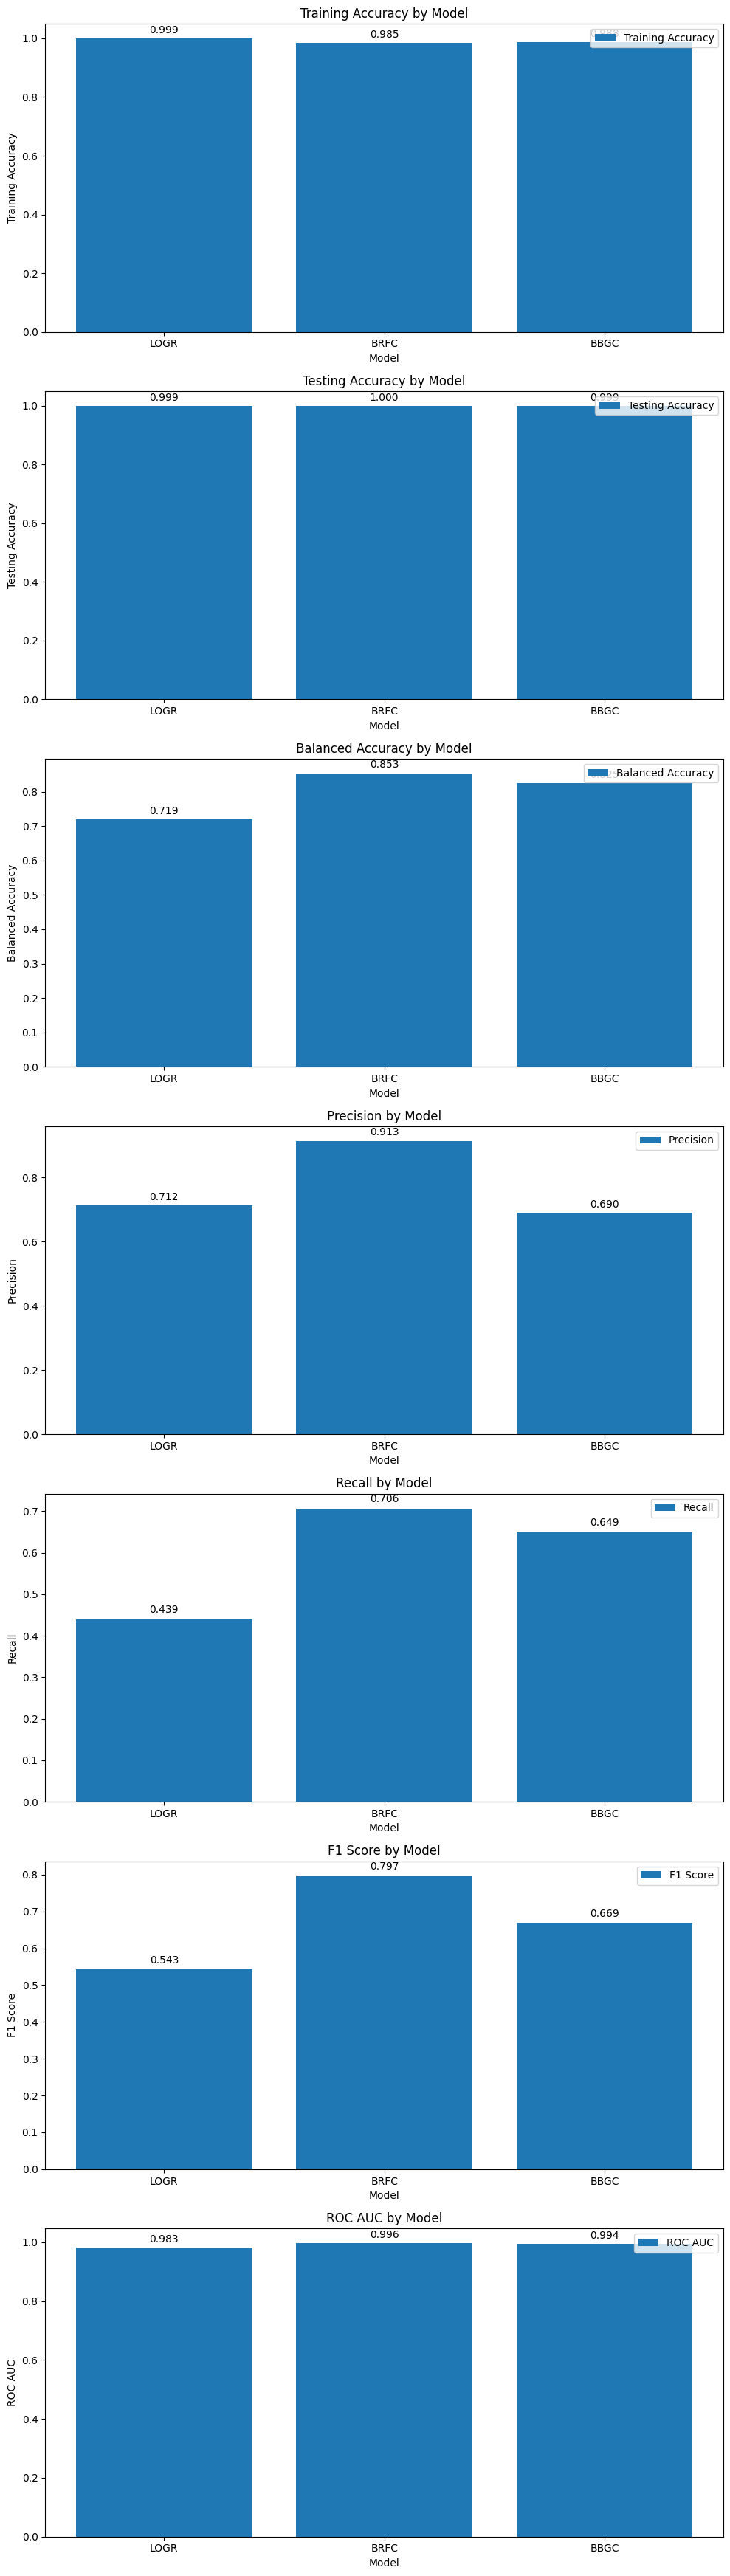

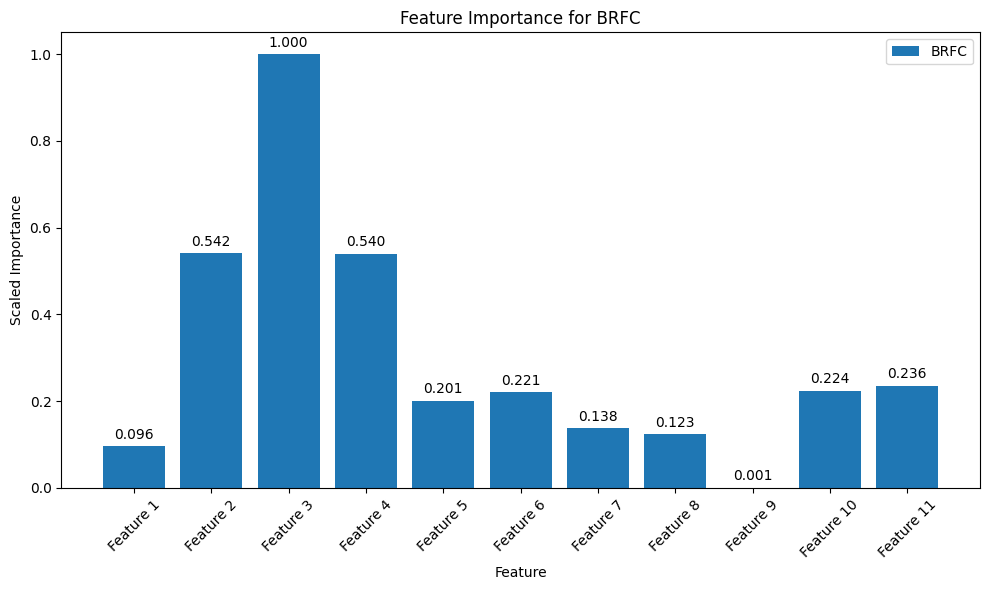


Best Parameters:
|    | Model   | Best Parameters                                                                                                 |
|----|---------|-----------------------------------------------------------------------------------------------------------------|
|  0 | LOGR    | {'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}                                                     |
|  1 | BRFC    | {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}                         |
|  2 | BBGC    | {'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200} |


In [37]:
#emake some edits to how the labels appear , make them less congested

test_metrics_1 , best_params_1 , feature_importance_1 = evaluate_models_f(X_train , y_train , X_test, y_test,model_param_grid_1)


Overall Progress:   0%|          | 0/3 [00:00<?, ?model/s]

Running model HistGradientBoostingClassifier (1/3)...



Overall Progress: 1/3 models:  33%|███▎      | 1/3 [10:00<20:01, 600.56s/model]

Model HistGradientBoostingClassifier completed in 600.55 seconds.
Running model XGBClassifier (2/3)...



Overall Progress: 2/3 models:  67%|██████▋   | 2/3 [2:30:47<1:26:56, 5216.14s/model]

Model XGBClassifier completed in 8446.94 seconds.
Running model LGBMClassifier (3/3)...



Overall Progress: 3/3 models: 100%|██████████| 3/3 [3:14:19<00:00, 3886.61s/model]

Model LGBMClassifier completed in 2612.21 seconds.

Test Metrics:
|    | Model   |   Training Accuracy |   Testing Accuracy |   Balanced Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |   Optimal Threshold |
|----|---------|---------------------|--------------------|---------------------|-------------|----------|------------|-----------|---------------------|
|  0 | HGBC    |            0.999886 |           0.999598 |            0.812758 |    0.823241 | 0.625622 |   0.710954 |  0.880706 |            0.565657 |
|  1 | XGBC    |            0.998366 |           0.999395 |            0.631208 |    0.901709 | 0.262438 |   0.406551 |  0.95282  |            0.292929 |
|  2 | LGBC    |            0.996877 |           0.999241 |            0.577069 |    0.571429 | 0.154229 |   0.242899 |  0.903407 |            0.626263 |


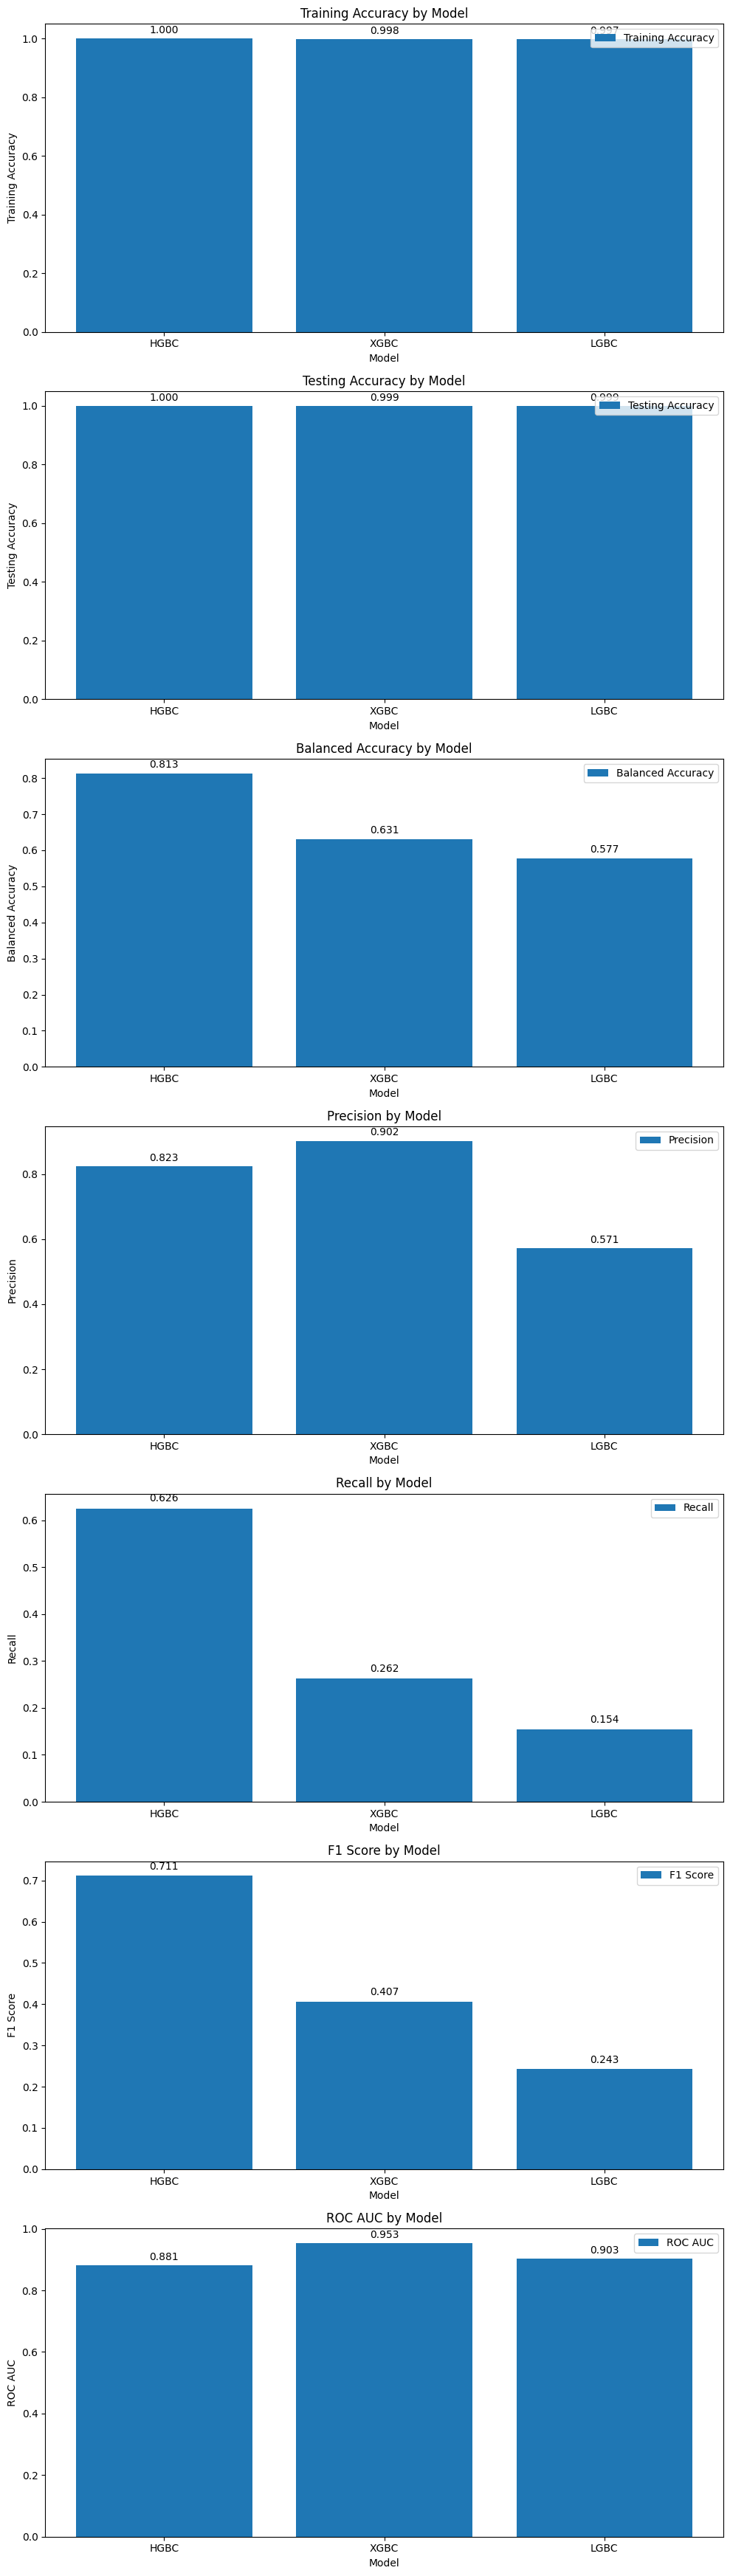

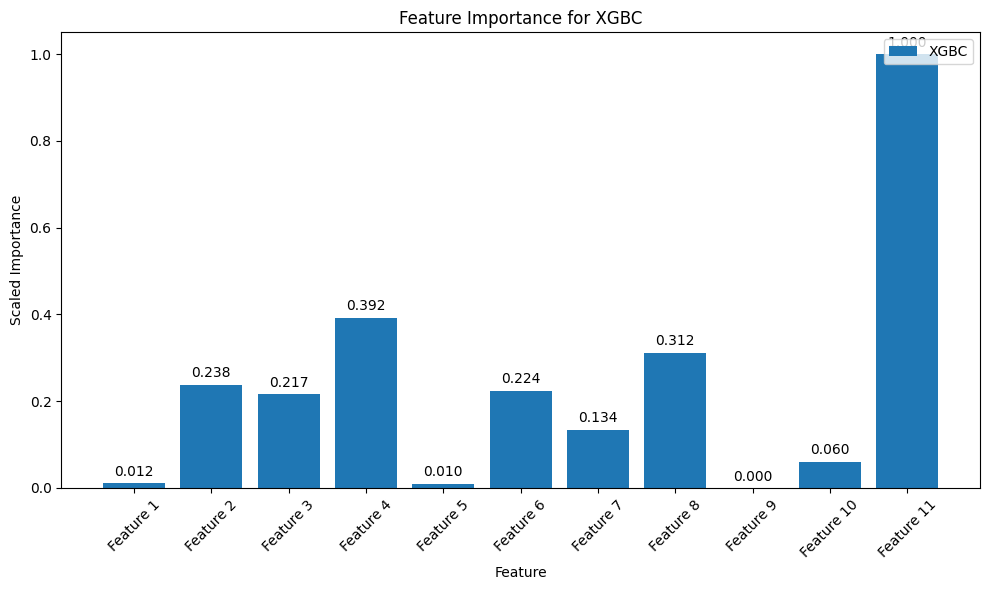

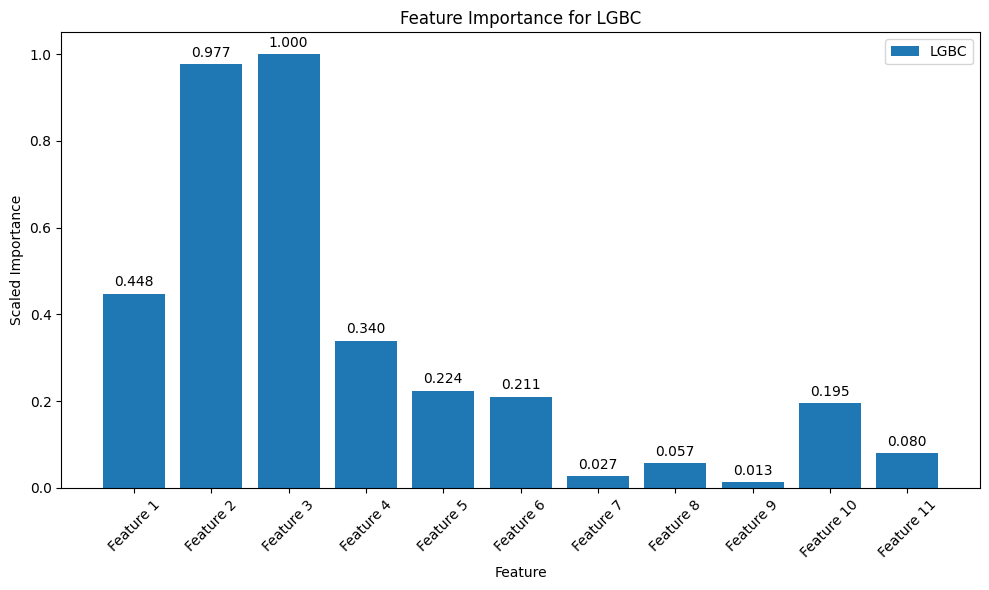


Best Parameters:
|    | Model   | Best Parameters                                                                                                                                                                                                                                                                                                     |
|----|---------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | HGBC    | {'learning_rate': 0.01, 'max_depth': None, 'max_iter': 500, 'min_samples_leaf': 20}                                                                                                                                                                                                                                 |
|

In [13]:
test_metrics_2 , best_params_1 , feature_importance_1 = evaluate_models_f(X_train,y_train,X_test ,y_test,model_param_grid_2)

In [11]:
def data_transformations_feature_removal(data, features_to_remove):
    if 'isFraud' in data.columns:
        labels = data['isFraud']
        data = data.drop('isFraud', axis=1)
    if "nameOrig" in data.columns and "nameDest" in data.columns:
        data.drop(["nameOrig", "nameDest"], axis=1, inplace=True)
    
    preprocessed_data = preprocessing.fit_transform(data)
    
    # Get feature names before removal
    features = preprocessing.get_feature_names_out()
    
    # Remove features based on indices
    preprocessed_data = np.delete(preprocessed_data, features_to_remove, axis=1)
    
    # Update the list of features after removal
    remaining_features = np.delete(features, features_to_remove)
    
    labels = labels.to_numpy()
    return preprocessed_data, labels, remaining_features

In [12]:
features_to_remove = [0,4,6,7,8]
X_train, y_train, f_train = data_transformations_feature_removal(strat_test_set,features_to_remove)
X_test, y_test, f_test = data_transformations_feature_removal(strat_test_set_1,features_to_remove)
X_test_1, y_test_1, f_test = data_transformations_feature_removal(strat_test_set_2,features_to_remove)
X_test_3, y_test_3 , f_test_3 = data_transformations_feature_removal(strat_test_set_3,features_to_remove)
X_test_4, y_test_4 , f_test_4 = data_transformations_feature_removal(strat_test_set_4,features_to_remove)
X_test_5,y_test_5 , feat_5 = data_transformations_feature_removal(strat_test_set_5,features_to_remove)
X_test_6,y_test_6 , feat_6 = data_transformations_feature_removal(strat_test_set_6,features_to_remove)
X_test_7,y_test_7 , feat_7 = data_transformations_feature_removal(strat_test_set_7,features_to_remove)

X_train_w , y_train_w , feat_train_w = data_transformations_feature_removal(strat_train_set_f,features_to_remove)
X_test_w , y_test_w , feat_test_w = data_transformations_feature_removal(strat_test_set_f,features_to_remove)

In [14]:
feat_train_w

array(['pipeline-1__amount', 'pipeline-1__oldbalanceOrg',
       'pipeline-1__newbalanceOrig', 'pipeline-1__newbalanceDest',
       'pipeline-2__type_PAYMENT', 'pipeline-2__type_TRANSFER'],
      dtype=object)

In [11]:

BRC = BalancedRandomForestClassifier(max_depth = None, min_samples_leaf = 1
                                     ,min_samples_split = 5, n_estimators = 500,n_jobs=-1, verbose=0, random_state=42)
BRC.fit(X_train_w,y_train_w)

BalancedRandomForestClassifier(min_samples_split=5, n_estimators=500, n_jobs=-1,
                               random_state=42)

In [12]:
def predict_and_evaluate(X_test, y_test, calibrated_model, avg_optimal_threshold):
    # Predict probabilities on the new test data
    y_preds_proba = calibrated_model.predict_proba(X_test)[:, 1]

    # Use the average optimal threshold obtained from nested cross-validation
    y_preds = (y_preds_proba >= avg_optimal_threshold).astype(int)
    
    # Calculate metrics
    balanced_acc = balanced_accuracy_score(y_test, y_preds)
    val_acc = accuracy_score(y_test, y_preds)
    precision_val = precision_score(y_test, y_preds)
    recall_val = recall_score(y_test, y_preds)
    f1_val = f1_score(y_test, y_preds)
    roc_auc_val = roc_auc_score(y_test, y_preds_proba)

    # Print metrics in a table
    metrics = [["Validation Accuracy", val_acc],
               ["Balanced Accuracy", balanced_acc],
               ["Precision", precision_val],
               ["Recall", recall_val],
               ["F1 Score", f1_val],
               ["ROC AUC", roc_auc_val]]
    
    print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

def predict_evaluate_prob(X_test, y_test, calibrated_model):
    y_preds_proba = calibrated_model.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.0, 1.1, 0.1)
    precision_vals = []
    recall_vals = []
    f1_vals = []

    for threshold in thresholds:
        y_preds = (y_preds_proba >= threshold).astype(int)
        precision_vals.append(precision_score(y_test, y_preds))
        recall_vals.append(recall_score(y_test, y_preds))
        f1_vals.append(f1_score(y_test, y_preds))
    
    # Find the optimal threshold for each metric
    optimal_precision_threshold = thresholds[np.argmax(precision_vals)]
    optimal_recall_threshold = thresholds[np.argmax(recall_vals)]
    optimal_f1_threshold = thresholds[np.argmax(f1_vals)]

    # Plot the metrics against thresholds
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precision_vals, label='Precision', marker='o')
    plt.plot(thresholds, recall_vals, label='Recall', marker='o')
    plt.plot(thresholds, f1_vals, label='F1 Score', marker='o')

    # Highlight optimal thresholds
    plt.axvline(x=optimal_precision_threshold, color='r', linestyle='--', label=f'Optimal Precision Threshold ({optimal_precision_threshold:.2f})')
    plt.axvline(x=optimal_recall_threshold, color='g', linestyle='--', label=f'Optimal Recall Threshold ({optimal_recall_threshold:.2f})')
    plt.axvline(x=optimal_f1_threshold, color='b', linestyle='--', label=f'Optimal F1 Threshold ({optimal_f1_threshold:.2f})')

    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('Metrics vs Probability Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()






In [21]:
predict_and_evaluate(X_test_5,y_test_5,BRC,0.624383)

+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Validation Accuracy | 0.999673 |
+---------------------+----------+
| Balanced Accuracy   | 0.8468   |
+---------------------+----------+
| Precision           | 0.850158 |
+---------------------+----------+
| Recall              | 0.693694 |
+---------------------+----------+
| F1 Score            | 0.763997 |
+---------------------+----------+
| ROC AUC             | 0.997572 |
+---------------------+----------+


In [20]:
predict_and_evaluate(X_test_7,y_test_7,BRC,0.624383)

+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Validation Accuracy | 0.999528 |
+---------------------+----------+
| Balanced Accuracy   | 0.728619 |
+---------------------+----------+
| Precision           | 0.881356 |
+---------------------+----------+
| Recall              | 0.457286 |
+---------------------+----------+
| F1 Score            | 0.602151 |
+---------------------+----------+
| ROC AUC             | 0.986509 |
+---------------------+----------+


In [30]:
predict_and_evaluate(X_test_w,y_test_w,BRC,0.65)

+---------------------+----------+
| Metric              |    Value |
+=====================+==========+
| Validation Accuracy | 0.999568 |
+---------------------+----------+
| Balanced Accuracy   | 0.848731 |
+---------------------+----------+
| Precision           | 0.955796 |
+---------------------+----------+
| Recall              | 0.697505 |
+---------------------+----------+
| F1 Score            | 0.806474 |
+---------------------+----------+
| ROC AUC             | 0.998841 |
+---------------------+----------+


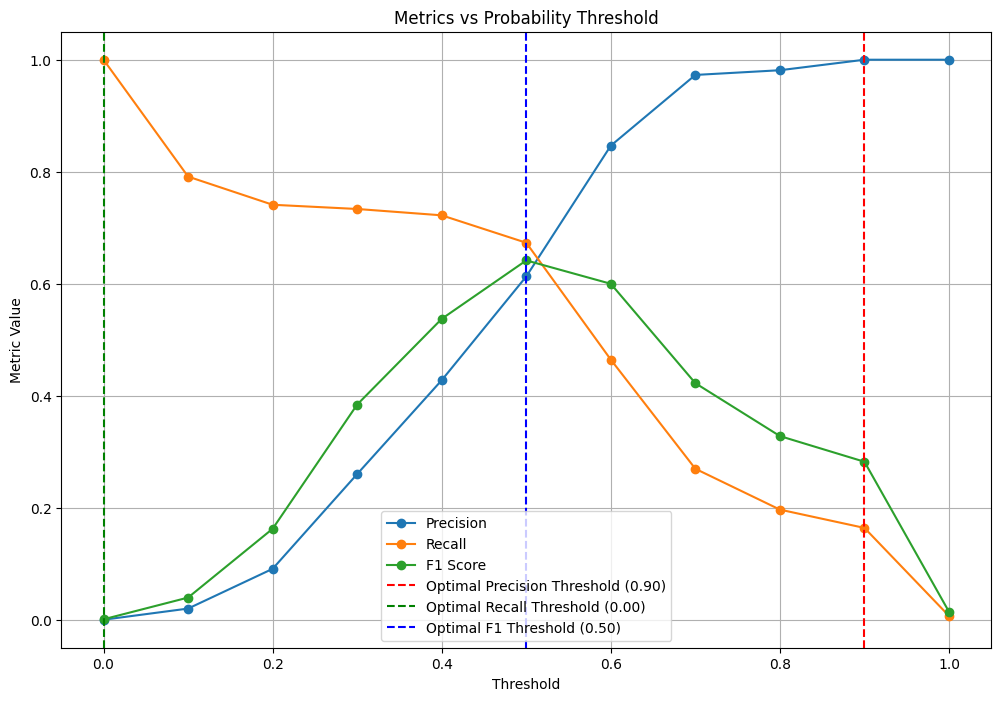

In [24]:
predict_evaluate_prob(X_test_7,y_test_7,BRC)

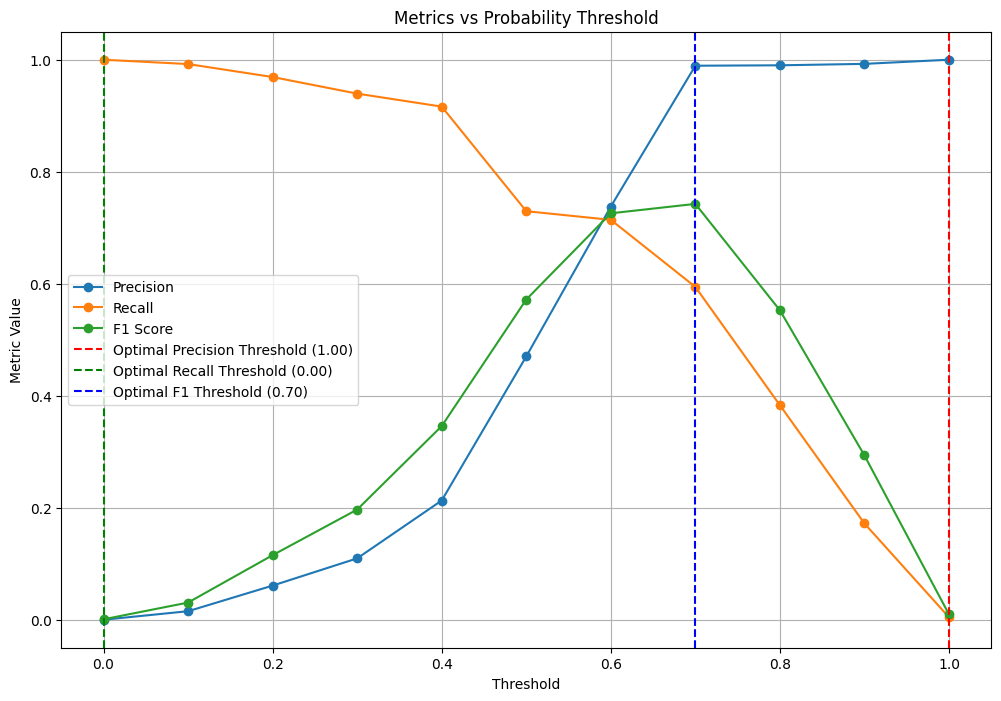

In [25]:
predict_evaluate_prob(X_test_5,y_test_5,BRC)

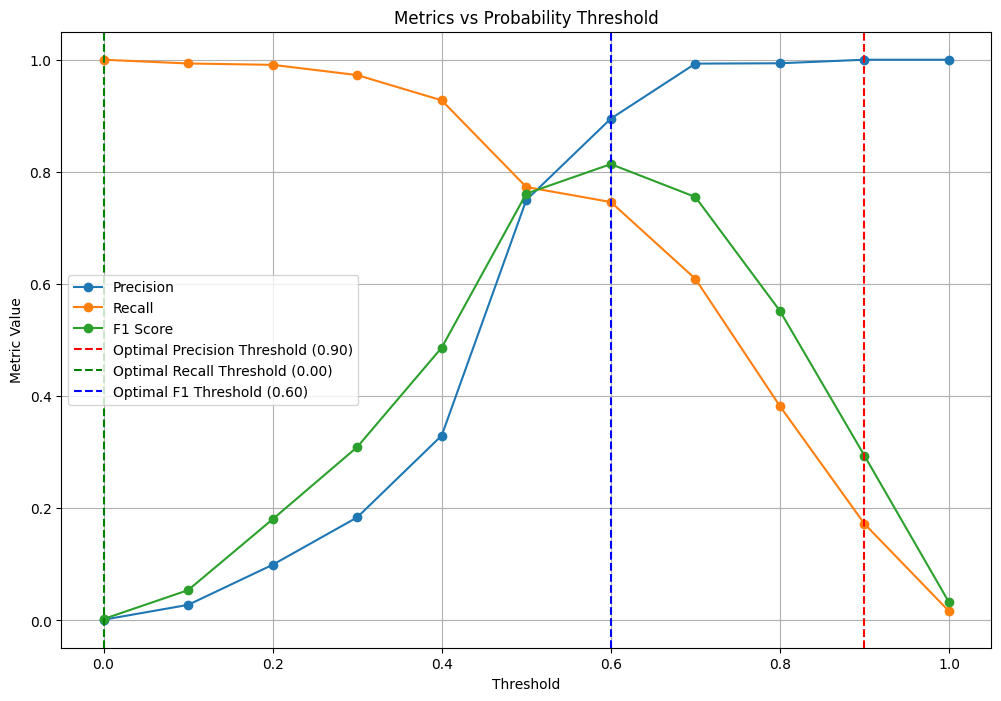

In [13]:
predict_evaluate_prob(X_test_w,y_test_w,BRC)

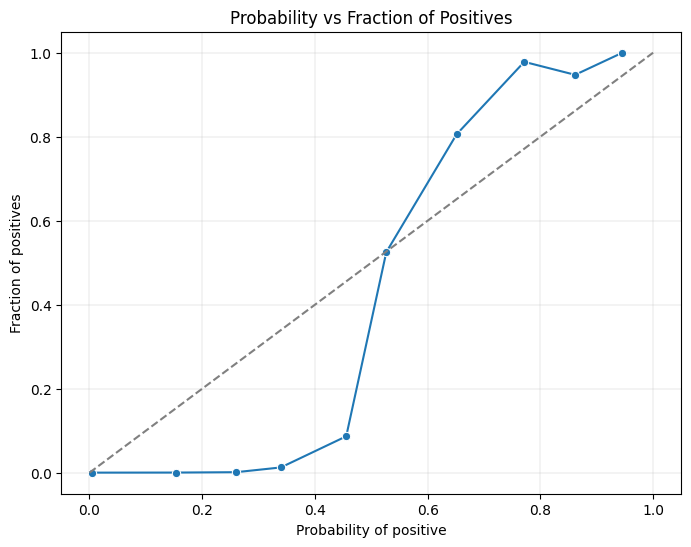

In [12]:

def plot_calibration_curve(model, X_test, y_test, n_bins=10):
   
   
    y_pred = model.predict_proba(X_test)[:, 1]

    frac_of_positives, pred_prob = calibration_curve(y_test, y_pred, n_bins=n_bins)

    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 10})
    sns.lineplot(x=pred_prob, y=frac_of_positives, marker='o')
    plt.grid(linestyle='-', linewidth=0.2)
    plt.title("Probability vs Fraction of Positives")
    plt.xlabel("Probability of positive")
    plt.ylabel("Fraction of positives")
    ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.show()


plot_calibration_curve(BRC, X_test, y_test)


In [14]:
import joblib
f_model = BRC

In [17]:
joblib.dump(f_model, 'C:\\Users\\swaga\\Desktop\\Desktop_files\\Project_001\\web_hosting\\model.pkl')

['C:\\Users\\swaga\\Desktop\\Desktop_files\\Project_001\\web_hosting\\model.pkl']